# exp02: AirREGI入電数 翌日予測 with CatBoost & featurewiz

## 目的
- 時系列リーケージを絶対に起こさず、翌日のcall_numを予測
- featurewizを使った特徴量選定（train期間のみ）
- strict（当日外生変数除外）/ relaxed（当日外生変数含む）の2パターンで評価
- 各パターンで「全特徴量」vs「featurewiz選定」を比較

## リーケージ防止策
1. 目的変数 y = call_num.shift(-1) で翌日予測
2. 時系列分割（最後60日をtest、残りをtrain）
3. featurewizは **train期間のみ** で実行
4. 目的変数由来列（call_diff*, call_change*, above_ma7等）を削除
5. strict版では当日外生変数（acc_get_cnt, search_cnt等）も除外

In [71]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import re
import warnings
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Imports complete")

✅ Imports complete


In [72]:
# 2) Config
# 実行環境に応じて自動でパスを選択
DATA_PATH_CANDIDATES = [
    "../input/airregi_features_verified_safe.csv",
    "input/airregi_features_verified_safe.csv",
    "kaggle-template/input/airregi_features_verified_safe.csv"
]

DATA_PATH = None
for path in DATA_PATH_CANDIDATES:
    if os.path.exists(path):
        DATA_PATH = path
        break

if DATA_PATH is None:
    raise FileNotFoundError(f"Data file not found in any of: {DATA_PATH_CANDIDATES}")

print(f"✅ Using data path: {DATA_PATH}")

# Output directories
OUTPUT_BASE = Path("../output/exp02")
OUTPUT_STRICT = OUTPUT_BASE / "strict"
OUTPUT_RELAXED = OUTPUT_BASE / "relaxed"

for d in [OUTPUT_BASE, OUTPUT_STRICT, OUTPUT_RELAXED]:
    d.mkdir(parents=True, exist_ok=True)

# Constants
TEST_DAYS = 60
RANDOM_SEED = 42

print(f"✅ Output directories created")

✅ Using data path: ../input/airregi_features_verified_safe.csv
✅ Output directories created


In [73]:
# 3) Load & Sanity Check
df = pd.read_csv(DATA_PATH, parse_dates=['cdr_date'])
print(f"Loaded data: {df.shape}")
print(f"Date range: {df['cdr_date'].min()} to {df['cdr_date'].max()}")

# Sort by date (ascending) - CRITICAL for time series
df = df.sort_values('cdr_date').reset_index(drop=True)

# Check for duplicates
dup_count = df['cdr_date'].duplicated().sum()
assert dup_count == 0, f"Found {dup_count} duplicate dates!"

print("✅ Data sorted and no duplicates confirmed")
print(f"\nFirst 3 rows:")
print(df[['cdr_date', 'call_num', 'acc_get_cnt', 'search_cnt']].head(3))

Loaded data: (670, 205)
Date range: 2018-06-01 00:00:00 to 2020-03-31 00:00:00
✅ Data sorted and no duplicates confirmed

First 3 rows:
    cdr_date  call_num  acc_get_cnt  search_cnt
0 2018-06-01       183    -0.282652        18.0
1 2018-06-02         0    -1.025720        18.0
2 2018-06-03         0    -1.075258        18.0


In [74]:
# 4) Target Creation: y = call_num.shift(-1) for next-day prediction
df['y'] = df['call_num'].shift(-1)

print(f"Created target 'y' (next day's call_num)")
print(f"Rows before dropna: {len(df)}")

# Drop rows where y is NaN (last row)
df = df.dropna(subset=['y']).reset_index(drop=True)

print(f"Rows after dropna: {len(df)}")
print(f"\nSample:")
print(df[['cdr_date', 'call_num', 'y']].tail(5))

print("\n✅ Target variable 'y' created (翌日予測)")

Created target 'y' (next day's call_num)
Rows before dropna: 670
Rows after dropna: 669

Sample:
      cdr_date  call_num      y
664 2020-03-26       114  127.0
665 2020-03-27       127    0.0
666 2020-03-28         0    0.0
667 2020-03-29         0  134.0
668 2020-03-30       134  101.0

✅ Target variable 'y' created (翌日予測)


In [75]:
# 5) Leak-Guard: Drop target-derived columns
# These columns contain information derived from call_num (target leakage)
LEAK_PATTERNS = [
    r'^call_diff',      # call_diff, call_diff_ma3, etc.
    r'^call_change',    # call_change_*
    r'above_ma',        # above_ma7, etc.
    r'trend_direction', # trend signals
    r'below_threshold', # threshold-based flags
    r'call_7dma$',      # 7-day moving average of target (if exists)
    r'call_ma',         # call_ma3, call_ma5, call_ma7, etc. - LEAKAGE!
    r'call_std',        # call_std3, call_std7, etc. - LEAKAGE!
    r'call_cv',         # coefficient of variation
    r'call_rolling',    # call_rolling_p90, call_rolling_p10
    r'is_high_volume_day_prev',  # derived from call_num
    r'is_low_volume_day_prev',   # derived from call_num
    r'was_surge_yesterday',      # derived from call_num
    r'was_drop_yesterday',       # derived from call_num
    r'mean_reversion_signal',    # derived from call_num
    r'short_above_long_ma',      # derived from call_num
    r'ma_crossover_signal',      # derived from call_num
    r'call_ma20',                # derived from call_num
    r'call_std20',               # derived from call_num
    r'bollinger',                # bollinger bands - derived from call_num
    r'rsi$',                     # RSI - derived from call_num
    r'ema12',                    # EMA - derived from call_num
    r'ema26',                    # EMA - derived from call_num
    r'macd',                     # MACD - derived from call_num
    r'^gain$',                   # gain/loss for RSI
    r'^loss$',
    r'avg_gain',
    r'avg_loss',
]

# LAG columns are OK (call_lag1, call_lag7 etc.) - they use past data only

dropped_cols = []
for col in df.columns:
    for pattern in LEAK_PATTERNS:
        if re.search(pattern, col, re.IGNORECASE):
            dropped_cols.append(col)
            break

if dropped_cols:
    print(f"🚨 DROPPING {len(dropped_cols)} target-derived (LEAKAGE) columns:")
    for col in sorted(dropped_cols):
        print(f"   - {col}")
    df = df.drop(columns=dropped_cols)
else:
    print("✅ No obvious leakage columns found")

print(f"\nRemaining columns: {len(df.columns)}")

🚨 DROPPING 34 target-derived (LEAKAGE) columns:
   - avg_gain
   - avg_loss
   - bollinger_lower
   - bollinger_position
   - bollinger_upper
   - call_7dma
   - call_cv7
   - call_ma14
   - call_ma20
   - call_ma3
   - call_ma30
   - call_ma5
   - call_ma7
   - call_rolling_p10
   - call_rolling_p90
   - call_std14
   - call_std20
   - call_std3
   - call_std7
   - ema12
   - ema26
   - gain
   - is_high_volume_day_prev
   - is_low_volume_day_prev
   - loss
   - ma_crossover_signal
   - macd
   - macd_histogram
   - macd_signal
   - mean_reversion_signal
   - rsi
   - short_above_long_ma
   - was_drop_yesterday
   - was_surge_yesterday

Remaining columns: 172


In [76]:
# 6) Time Split: Last 60 days = test, rest = train
# NO random split, NO KFold with shuffle
split_date = df['cdr_date'].max() - pd.Timedelta(days=TEST_DAYS)

train_df = df[df['cdr_date'] < split_date].copy().reset_index(drop=True)
test_df = df[df['cdr_date'] >= split_date].copy().reset_index(drop=True)

print(f"Split date: {split_date}")
print(f"Train period: {train_df['cdr_date'].min()} to {train_df['cdr_date'].max()} ({len(train_df)} rows)")
print(f"Test period:  {test_df['cdr_date'].min()} to {test_df['cdr_date'].max()} ({len(test_df)} rows)")

print("\n✅ Time-based split completed (NO LEAKAGE)")

Split date: 2020-01-30 00:00:00
Train period: 2018-06-01 00:00:00 to 2020-01-29 00:00:00 (608 rows)
Test period:  2020-01-30 00:00:00 to 2020-03-30 00:00:00 (61 rows)

✅ Time-based split completed (NO LEAKAGE)


In [77]:
# 7) Feature Set Creation
# Exclude: cdr_date (identifier), call_num (used for y), y (target)
EXCLUDE_COLS = ['cdr_date', 'call_num', 'y']

# For STRICT: also exclude same-day exogenous variables
# (In production, we won't have today's acc_get_cnt or search_cnt)
STRICT_EXCLUDE_ADDITIONAL = [
    'acc_get_cnt',  # Same-day account acquisition
    'search_cnt',   # Same-day Google Trends
    # Keep lag versions if they exist (acc_lag1, etc.)
]

# Get all feature candidates (everything except excluded)
all_feature_cols = [c for c in train_df.columns if c not in EXCLUDE_COLS]

# STRICT features: remove same-day exogenous
strict_feature_cols = [c for c in all_feature_cols if c not in STRICT_EXCLUDE_ADDITIONAL]

# RELAXED features: use all available features
relaxed_feature_cols = all_feature_cols.copy()

print(f"Total feature candidates: {len(all_feature_cols)}")
print(f"STRICT features (no same-day exogenous): {len(strict_feature_cols)}")
print(f"RELAXED features (all available): {len(relaxed_feature_cols)}")

print(f"\nExcluded from STRICT:")
for col in STRICT_EXCLUDE_ADDITIONAL:
    if col in all_feature_cols:
        print(f"   - {col}")

print("\n✅ Feature sets defined")

Total feature candidates: 169
STRICT features (no same-day exogenous): 167
RELAXED features (all available): 169

Excluded from STRICT:
   - acc_get_cnt
   - search_cnt

✅ Feature sets defined


In [78]:
# 8) Metrics Functions
def calculate_metrics(y_true, y_pred, df_subset=None):
    """
    Calculate MAE, RMSE for overall and is_open_day==1 subset
    """
    metrics = {}
    
    # Overall metrics
    metrics['mae_all'] = mean_absolute_error(y_true, y_pred)
    metrics['rmse_all'] = mean_squared_error(y_true, y_pred, squared=False)
    
    # is_open_day==1 metrics (if column exists)
    if df_subset is not None and 'is_open_day' in df_subset.columns:
        open_mask = df_subset['is_open_day'] == 1
        if open_mask.sum() > 0:
            metrics['mae_open_day'] = mean_absolute_error(
                y_true[open_mask], y_pred[open_mask]
            )
            metrics['rmse_open_day'] = mean_squared_error(
                y_true[open_mask], y_pred[open_mask], squared=False
            )
        else:
            metrics['mae_open_day'] = None
            metrics['rmse_open_day'] = None
    else:
        metrics['mae_open_day'] = None
        metrics['rmse_open_day'] = None
    
    return metrics

def print_metrics(metrics, label=""):
    """Pretty print metrics"""
    print(f"\n{'='*60}")
    print(f"{label}")
    print(f"{'='*60}")
    print(f"MAE (all):       {metrics['mae_all']:.3f}")
    print(f"RMSE (all):      {metrics['rmse_all']:.3f}")
    if metrics['mae_open_day'] is not None:
        print(f"MAE (open_day):  {metrics['mae_open_day']:.3f}")
        print(f"RMSE (open_day): {metrics['rmse_open_day']:.3f}")
    print(f"{'='*60}")

print("✅ Metrics functions defined")

✅ Metrics functions defined


In [79]:
# 9) Naive Baseline Evaluation
# Baseline: y_hat(t+1) = call_num(t)
baseline_pred = test_df['call_num'].values
baseline_metrics = calculate_metrics(
    test_df['y'].values,
    baseline_pred,
    test_df
)

print_metrics(baseline_metrics, "BASELINE: y_hat(t+1) = call_num(t)")

# Store for summary
summary_results = {
    'baseline': baseline_metrics
}


BASELINE: y_hat(t+1) = call_num(t)
MAE (all):       57.131
RMSE (all):      83.469
MAE (open_day):  50.375
RMSE (open_day): 71.716


In [80]:
# 10) Helper Functions for CatBoost Training
def get_categorical_features(df, feature_cols):
    """
    Auto-detect categorical features based on dtype
    """
    cat_features = []
    for col in feature_cols:
        if col in df.columns:
            dtype = df[col].dtype
            if dtype in ['object', 'category', 'bool']:
                cat_features.append(col)
    return cat_features

def train_catboost(X_train, y_train, X_test, y_test, cat_features=None, label=""):
    """
    Train CatBoost with early stopping
    """
    print(f"\n{'='*60}")
    print(f"Training CatBoost: {label}")
    print(f"{'='*60}")
    print(f"Train shape: {X_train.shape}")
    print(f"Test shape:  {X_test.shape}")
    
    if cat_features:
        print(f"Categorical features: {len(cat_features)}")
    
    model = CatBoostRegressor(
        iterations=20000,
        learning_rate=0.03,
        depth=8,
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=RANDOM_SEED,
        verbose=False,
        # early_stopping_rounds=100,
        cat_features=cat_features if cat_features else None
    )
    
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        use_best_model=True
    )
    
    print(f"Best iteration: {model.get_best_iteration()}")
    print(f"Best score: {model.get_best_score()['validation']['MAE']:.3f}")
    
    return model

def save_results(model, X_test, y_test, test_df, output_dir, prefix=""):
    """
    Save model, predictions, feature importance, and plot
    """
    output_dir = Path(output_dir)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    metrics = calculate_metrics(y_test, y_pred, test_df)
    
    # Save predictions
    pred_df = pd.DataFrame({
        'cdr_date': test_df['cdr_date'],
        'y_true': y_test,
        'y_pred': y_pred,
        'error': y_pred - y_test,
        'abs_error': np.abs(y_pred - y_test)
    })
    pred_df.to_csv(output_dir / f"predictions_{prefix}.csv", index=False)
    
    # Save metrics
    with open(output_dir / f"metrics_{prefix}.json", 'w') as f:
        json.dump(metrics, f, indent=2)
    
    # Save feature importance
    importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    importance_df.to_csv(output_dir / f"feature_importance_{prefix}.csv", index=False)
    
    # Save model
    model.save_model(str(output_dir / f"catboost_model_{prefix}.cbm"))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(pred_df['cdr_date'], pred_df['y_true'], label='Actual', marker='o', alpha=0.7)
    ax.plot(pred_df['cdr_date'], pred_df['y_pred'], label='Predicted', marker='x', alpha=0.7)
    ax.set_xlabel('Date')
    ax.set_ylabel('Call Number')
    ax.set_title(f'{prefix}: MAE={metrics["mae_all"]:.2f}, RMSE={metrics["rmse_all"]:.2f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_dir / f"pred_plot_{prefix}.png", dpi=150)
    plt.close()
    
    print(f"\n✅ Saved results to {output_dir}/{prefix}")
    print_metrics(metrics, f"{prefix} Results")
    
    return metrics, y_pred

print("✅ Helper functions defined")

✅ Helper functions defined


In [81]:
# 11) Install featurewiz if needed
try:
    import featurewiz
    print("✅ featurewiz already installed")
except ImportError:
    print("Installing featurewiz...")
    !pip install featurewiz -q
    import featurewiz
    print("✅ featurewiz installed")

✅ featurewiz already installed


## STRICT Feature Set

### 運用想定: 当日外生変数なし（lag系のみ）

In [82]:
# 12) STRICT: Prepare data (ALL features)
X_train_strict = train_df[strict_feature_cols].copy()
y_train_strict = train_df['y'].copy()
X_test_strict = test_df[strict_feature_cols].copy()
y_test_strict = test_df['y'].copy()

# Drop rows with NaN (if any)
train_mask = X_train_strict.notna().all(axis=1) & y_train_strict.notna()
test_mask = X_test_strict.notna().all(axis=1) & y_test_strict.notna()

X_train_strict = X_train_strict[train_mask].reset_index(drop=True)
y_train_strict = y_train_strict[train_mask].reset_index(drop=True)
X_test_strict = X_test_strict[test_mask].reset_index(drop=True)
y_test_strict = y_test_strict[test_mask].reset_index(drop=True)
test_df_strict = test_df[test_mask].reset_index(drop=True)

print(f"STRICT - Train: {X_train_strict.shape}, Test: {X_test_strict.shape}")

# Save feature list
with open(OUTPUT_STRICT / "selected_features_all.txt", 'w') as f:
    f.write("\n".join(strict_feature_cols))

print("✅ STRICT feature set (ALL) prepared")

STRICT - Train: (34, 167), Test: (4, 167)
✅ STRICT feature set (ALL) prepared


In [83]:
# 13) STRICT: Train CatBoost with ALL features
cat_features_strict = get_categorical_features(X_train_strict, strict_feature_cols)

model_strict_all = train_catboost(
    X_train_strict, y_train_strict,
    X_test_strict, y_test_strict,
    cat_features_strict,
    label="STRICT - ALL features"
)

# Save results
metrics_strict_all, pred_strict_all = save_results(
    model_strict_all,
    X_test_strict, y_test_strict, test_df_strict,
    OUTPUT_STRICT,
    prefix="all"
)

summary_results['strict_all'] = metrics_strict_all


Training CatBoost: STRICT - ALL features
Train shape: (34, 167)
Test shape:  (4, 167)
Categorical features: 7
Best iteration: 288
Best score: 48.816

✅ Saved results to ../output/exp02/strict/all

all Results
MAE (all):       48.816
RMSE (all):      49.889


In [84]:
# 14) STRICT: featurewiz selection (TRAIN ONLY - NO LEAKAGE!)
print("\n" + "="*60)
print("STRICT: Running featurewiz on TRAIN data only")
print("="*60)

import featurewiz as FW

# Prepare train data for featurewiz
train_fw_strict = X_train_strict.copy()
train_fw_strict['y'] = y_train_strict.values

# Run featurewiz (NO test_data, NO feature_engg)
selected_feats_strict, trainm_strict = FW.featurewiz(
    dataname=train_fw_strict,
    target="y",
    corr_limit=0.90,
    verbose=0,
    test_data="",           # NO TEST DATA - critical!
    feature_engg="",        # NO FEATURE ENGINEERING - only select
    category_encoders=""    # No encoding
)

print(f"\nfeaturewiz selected {len(selected_feats_strict)} features from {len(strict_feature_cols)}")
print(f"Selected features: {selected_feats_strict}")

# Save selected features
with open(OUTPUT_STRICT / "selected_features_featurewiz.txt", 'w') as f:
    f.write("\n".join(selected_feats_strict))

print("✅ STRICT featurewiz selection completed (train-only)")


STRICT: Running featurewiz on TRAIN data only
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
    Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
    Single_Label Regression problem 
    Loaded train data. Shape = (34, 168)
    Single_Label Regression problem 
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        20 variable(s) to be removed since ID or low-information variables
    	variables removed = ['days_from_start', 'days_to_tax_increase', 'days_from_tax_increase', 'holiday_flag', 'is_open_day', 'is_month_6', 'is_holiday', 'is_day_25', 'is_year_end', 'is_obon', 'is_fiscal_year_start', 'cm_x_tuesday', 'c

In [85]:
# 15) STRICT: Train CatBoost with featurewiz-selected features
X_train_strict_fw = X_train_strict[selected_feats_strict].copy()
X_test_strict_fw = X_test_strict[selected_feats_strict].copy()

cat_features_strict_fw = get_categorical_features(X_train_strict_fw, selected_feats_strict)

model_strict_fw = train_catboost(
    X_train_strict_fw, y_train_strict,
    X_test_strict_fw, y_test_strict,
    cat_features_strict_fw,
    label="STRICT - featurewiz selected"
)

# Save results
metrics_strict_fw, pred_strict_fw = save_results(
    model_strict_fw,
    X_test_strict_fw, y_test_strict, test_df_strict,
    OUTPUT_STRICT,
    prefix="featurewiz"
)

summary_results['strict_featurewiz'] = metrics_strict_fw


Training CatBoost: STRICT - featurewiz selected
Train shape: (34, 53)
Test shape:  (4, 53)
Categorical features: 4
Best iteration: 318
Best score: 43.695

✅ Saved results to ../output/exp02/strict/featurewiz

featurewiz Results
MAE (all):       43.695
RMSE (all):      51.553


## RELAXED Feature Set

### 比較用: 当日外生変数も含める

In [86]:
# 16) RELAXED: Prepare data (ALL features)
X_train_relaxed = train_df[relaxed_feature_cols].copy()
y_train_relaxed = train_df['y'].copy()
X_test_relaxed = test_df[relaxed_feature_cols].copy()
y_test_relaxed = test_df['y'].copy()

# Drop rows with NaN (if any)
train_mask = X_train_relaxed.notna().all(axis=1) & y_train_relaxed.notna()
test_mask = X_test_relaxed.notna().all(axis=1) & y_test_relaxed.notna()

X_train_relaxed = X_train_relaxed[train_mask].reset_index(drop=True)
y_train_relaxed = y_train_relaxed[train_mask].reset_index(drop=True)
X_test_relaxed = X_test_relaxed[test_mask].reset_index(drop=True)
y_test_relaxed = y_test_relaxed[test_mask].reset_index(drop=True)
test_df_relaxed = test_df[test_mask].reset_index(drop=True)

print(f"RELAXED - Train: {X_train_relaxed.shape}, Test: {X_test_relaxed.shape}")

# Save feature list
with open(OUTPUT_RELAXED / "selected_features_all.txt", 'w') as f:
    f.write("\n".join(relaxed_feature_cols))

print("✅ RELAXED feature set (ALL) prepared")

RELAXED - Train: (34, 169), Test: (4, 169)
✅ RELAXED feature set (ALL) prepared


In [87]:
# 17) RELAXED: Train CatBoost with ALL features
cat_features_relaxed = get_categorical_features(X_train_relaxed, relaxed_feature_cols)

model_relaxed_all = train_catboost(
    X_train_relaxed, y_train_relaxed,
    X_test_relaxed, y_test_relaxed,
    cat_features_relaxed,
    label="RELAXED - ALL features"
)

# Save results
metrics_relaxed_all, pred_relaxed_all = save_results(
    model_relaxed_all,
    X_test_relaxed, y_test_relaxed, test_df_relaxed,
    OUTPUT_RELAXED,
    prefix="all"
)

summary_results['relaxed_all'] = metrics_relaxed_all


Training CatBoost: RELAXED - ALL features
Train shape: (34, 169)
Test shape:  (4, 169)
Categorical features: 7
Best iteration: 383
Best score: 53.593

✅ Saved results to ../output/exp02/relaxed/all

all Results
MAE (all):       53.593
RMSE (all):      57.929


In [88]:
# 18) RELAXED: featurewiz selection (TRAIN ONLY - NO LEAKAGE!)
print("\n" + "="*60)
print("RELAXED: Running featurewiz on TRAIN data only")
print("="*60)

# Prepare train data for featurewiz
train_fw_relaxed = X_train_relaxed.copy()
train_fw_relaxed['y'] = y_train_relaxed.values

# Run featurewiz (NO test_data, NO feature_engg)
selected_feats_relaxed, trainm_relaxed = FW.featurewiz(
    dataname=train_fw_relaxed,
    target="y",
    corr_limit=0.90,
    verbose=0,
    test_data="",           # NO TEST DATA - critical!
    feature_engg="",        # NO FEATURE ENGINEERING - only select
    category_encoders=""    # No encoding
)

print(f"\nfeaturewiz selected {len(selected_feats_relaxed)} features from {len(relaxed_feature_cols)}")
print(f"Selected features: {selected_feats_relaxed}")

# Save selected features
with open(OUTPUT_RELAXED / "selected_features_featurewiz.txt", 'w') as f:
    f.write("\n".join(selected_feats_relaxed))

print("✅ RELAXED featurewiz selection completed (train-only)")


RELAXED: Running featurewiz on TRAIN data only
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
    Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
    Single_Label Regression problem 
    Loaded train data. Shape = (34, 170)
    Single_Label Regression problem 
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        20 variable(s) to be removed since ID or low-information variables
    	variables removed = ['days_from_start', 'days_to_tax_increase', 'days_from_tax_increase', 'holiday_flag', 'is_open_day', 'is_month_6', 'is_holiday', 'is_day_25', 'is_year_end', 'is_obon', 'is_fiscal_year_start', 'cm_x_tuesday', '

In [89]:
# 19) RELAXED: Train CatBoost with featurewiz-selected features
X_train_relaxed_fw = X_train_relaxed[selected_feats_relaxed].copy()
X_test_relaxed_fw = X_test_relaxed[selected_feats_relaxed].copy()

cat_features_relaxed_fw = get_categorical_features(X_train_relaxed_fw, selected_feats_relaxed)

model_relaxed_fw = train_catboost(
    X_train_relaxed_fw, y_train_relaxed,
    X_test_relaxed_fw, y_test_relaxed,
    cat_features_relaxed_fw,
    label="RELAXED - featurewiz selected"
)

# Save results
metrics_relaxed_fw, pred_relaxed_fw = save_results(
    model_relaxed_fw,
    X_test_relaxed_fw, y_test_relaxed, test_df_relaxed,
    OUTPUT_RELAXED,
    prefix="featurewiz"
)

summary_results['relaxed_featurewiz'] = metrics_relaxed_fw


Training CatBoost: RELAXED - featurewiz selected
Train shape: (34, 52)
Test shape:  (4, 52)
Categorical features: 3
Best iteration: 15727
Best score: 43.813

✅ Saved results to ../output/exp02/relaxed/featurewiz

featurewiz Results
MAE (all):       43.813
RMSE (all):      46.082


## Summary & Comparison

In [90]:
# 20) Create summary table
summary_df = pd.DataFrame({
    'Model': [
        'Baseline (naive)',
        'STRICT - All Features',
        'STRICT - featurewiz',
        'RELAXED - All Features',
        'RELAXED - featurewiz'
    ],
    'MAE_all': [
        baseline_metrics['mae_all'],
        metrics_strict_all['mae_all'],
        metrics_strict_fw['mae_all'],
        metrics_relaxed_all['mae_all'],
        metrics_relaxed_fw['mae_all']
    ],
    'RMSE_all': [
        baseline_metrics['rmse_all'],
        metrics_strict_all['rmse_all'],
        metrics_strict_fw['rmse_all'],
        metrics_relaxed_all['rmse_all'],
        metrics_relaxed_fw['rmse_all']
    ],
    'MAE_open_day': [
        baseline_metrics.get('mae_open_day'),
        metrics_strict_all.get('mae_open_day'),
        metrics_strict_fw.get('mae_open_day'),
        metrics_relaxed_all.get('mae_open_day'),
        metrics_relaxed_fw.get('mae_open_day')
    ],
    'RMSE_open_day': [
        baseline_metrics.get('rmse_open_day'),
        metrics_strict_all.get('rmse_open_day'),
        metrics_strict_fw.get('rmse_open_day'),
        metrics_relaxed_all.get('rmse_open_day'),
        metrics_relaxed_fw.get('rmse_open_day')
    ],
    'N_features': [
        0,
        len(strict_feature_cols),
        len(selected_feats_strict),
        len(relaxed_feature_cols),
        len(selected_feats_relaxed)
    ]
})

print("\n" + "="*80)
print("FINAL SUMMARY: All Models Comparison")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Save summary
summary_df.to_csv(OUTPUT_BASE / "summary_comparison.csv", index=False)

# Save as JSON
with open(OUTPUT_BASE / "summary_metrics.json", 'w') as f:
    json.dump(summary_results, f, indent=2)

print(f"\n✅ Summary saved to {OUTPUT_BASE}")


FINAL SUMMARY: All Models Comparison
                 Model   MAE_all  RMSE_all  MAE_open_day  RMSE_open_day  N_features
      Baseline (naive) 57.131148 83.469146        50.375      71.715933           0
 STRICT - All Features 48.816187 49.888862           NaN            NaN         167
   STRICT - featurewiz 43.695175 51.552537           NaN            NaN          53
RELAXED - All Features 53.592963 57.929265           NaN            NaN         169
  RELAXED - featurewiz 43.813300 46.081780           NaN            NaN          52

✅ Summary saved to ../output/exp02


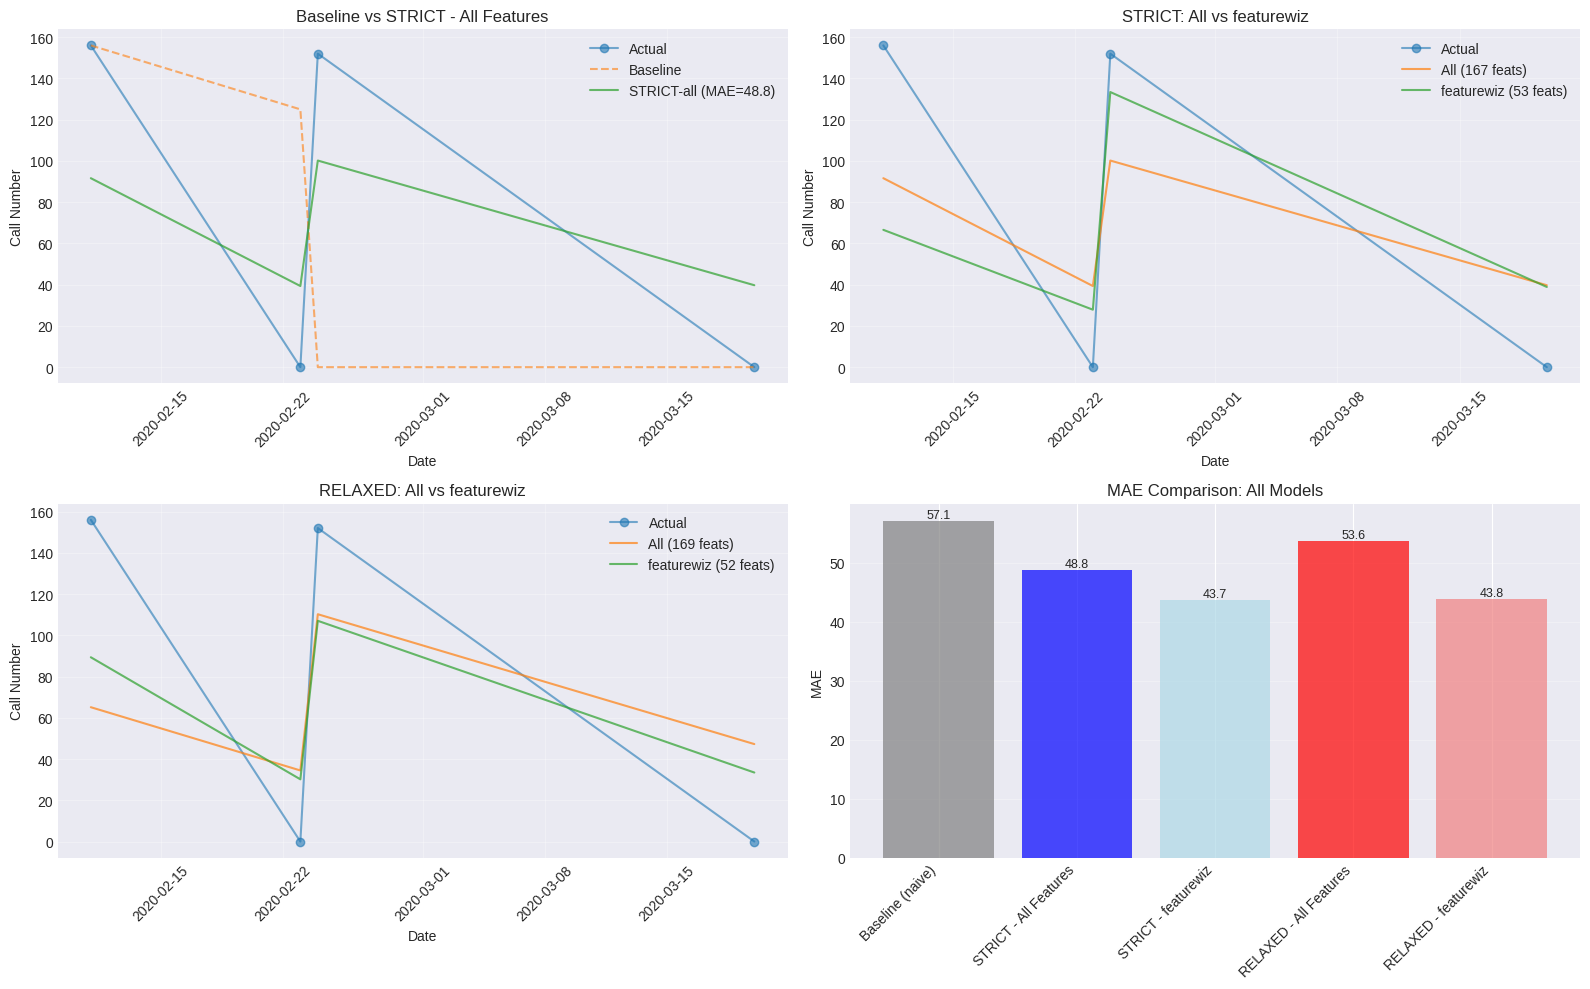


✅ Comparison plots saved to ../output/exp02


In [91]:
# 21) Visualization: Compare all models
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Baseline vs STRICT-all
ax = axes[0, 0]
ax.plot(test_df_strict['cdr_date'], y_test_strict, label='Actual', marker='o', alpha=0.6)
ax.plot(test_df_strict['cdr_date'], baseline_pred[:len(y_test_strict)], 
        label='Baseline', linestyle='--', alpha=0.6)
ax.plot(test_df_strict['cdr_date'], pred_strict_all, 
        label=f'STRICT-all (MAE={metrics_strict_all["mae_all"]:.1f})', alpha=0.7)
ax.set_title('Baseline vs STRICT - All Features')
ax.set_xlabel('Date')
ax.set_ylabel('Call Number')
ax.legend()
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# STRICT: all vs featurewiz
ax = axes[0, 1]
ax.plot(test_df_strict['cdr_date'], y_test_strict, label='Actual', marker='o', alpha=0.6)
ax.plot(test_df_strict['cdr_date'], pred_strict_all, 
        label=f'All ({len(strict_feature_cols)} feats)', alpha=0.7)
ax.plot(test_df_strict['cdr_date'], pred_strict_fw, 
        label=f'featurewiz ({len(selected_feats_strict)} feats)', alpha=0.7)
ax.set_title('STRICT: All vs featurewiz')
ax.set_xlabel('Date')
ax.set_ylabel('Call Number')
ax.legend()
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# RELAXED: all vs featurewiz
ax = axes[1, 0]
ax.plot(test_df_relaxed['cdr_date'], y_test_relaxed, label='Actual', marker='o', alpha=0.6)
ax.plot(test_df_relaxed['cdr_date'], pred_relaxed_all, 
        label=f'All ({len(relaxed_feature_cols)} feats)', alpha=0.7)
ax.plot(test_df_relaxed['cdr_date'], pred_relaxed_fw, 
        label=f'featurewiz ({len(selected_feats_relaxed)} feats)', alpha=0.7)
ax.set_title('RELAXED: All vs featurewiz')
ax.set_xlabel('Date')
ax.set_ylabel('Call Number')
ax.legend()
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# MAE comparison bar chart
ax = axes[1, 1]
models = summary_df['Model'].values
mae_values = summary_df['MAE_all'].values
colors = ['gray', 'blue', 'lightblue', 'red', 'lightcoral']
bars = ax.bar(range(len(models)), mae_values, color=colors, alpha=0.7)
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_ylabel('MAE')
ax.set_title('MAE Comparison: All Models')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, mae_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_BASE / "comparison_plots.png", dpi=150)
plt.show()

print(f"\n✅ Comparison plots saved to {OUTPUT_BASE}")

## ✅ Experiment Complete

### 成果物確認
- `output/exp02/summary_metrics.json` - 全モデルのメトリクス
- `output/exp02/summary_comparison.csv` - 比較表
- `output/exp02/comparison_plots.png` - 全モデル比較プロット
- `output/exp02/strict/` - STRICT版の全成果物
- `output/exp02/relaxed/` - RELAXED版の全成果物

### リーケージ防止策の確認
1. ✅ 目的変数: y = call_num.shift(-1)
2. ✅ 時系列分割（最後60日=test）
3. ✅ featurewizは **train期間のみ** で実行
4. ✅ 目的変数由来列を正規表現で除外
5. ✅ STRICT版では当日外生変数も除外

### 推奨モデル
- **運用向け**: STRICT版（当日外生変数なし）を推奨
- **精度重視**: RELAXED版で評価可能（ただし当日データ取得が前提）

In [92]:
print("HORIZON:", HORIZON, "TEST_DAYS:", TEST_DAYS)
print("train date:", train_df["date"].min(), "->", train_df["date"].max(), "n=", len(train_df))
print("test  date:", test_df["date"].min(),  "->", test_df["date"].max(),  "n=", len(test_df))

# naiveを「同じtest行」で必ず計算
naive_pred = test_df["call_num"].astype(float).values
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
print("naive MAE:", mean_absolute_error(test_df["y"], naive_pred))
print("naive RMSE:", np.sqrt(mean_squared_error(test_df["y"], naive_pred)))

# リーク列が残ってないか
bad = [c for c in test_df.columns if any(k in c.lower() for k in ["above_ma", "trend_direction", "call_diff", "call_change", "diff_ma"])]
print("leak-like cols:", bad)


NameError: name 'HORIZON' is not defined

exp02 STRICT - All Features

Top 20 features (All Features):
                  feature  importance
0             search_x_cm    5.372817
1           week_position    3.801901
2       search_cnt_scaled    3.739482
3                acc_diff    3.496519
4            search_lag1w    3.068485
5               call_lag2    3.042636
6                 acc_ma7    3.004879
7                acc_lag5    2.828029
8                  season    2.784766
9                dow_name    2.542667
10   days_to_tax_increase    2.503553
11            search_diff    2.468239
12              call_lag7    2.369718
13              is_monday    2.359414
14        day_of_year_cos    2.359074
15  external_factor_score    2.128954
16                  month    2.099179
17        cm_count_last30    2.027165
18        cm_count_last14    1.866868
19               acc_ma14    1.803927

Top 20 features (featurewiz):
                 feature  importance
0             call_lag21    7.713500
1               dow_name    6.275677

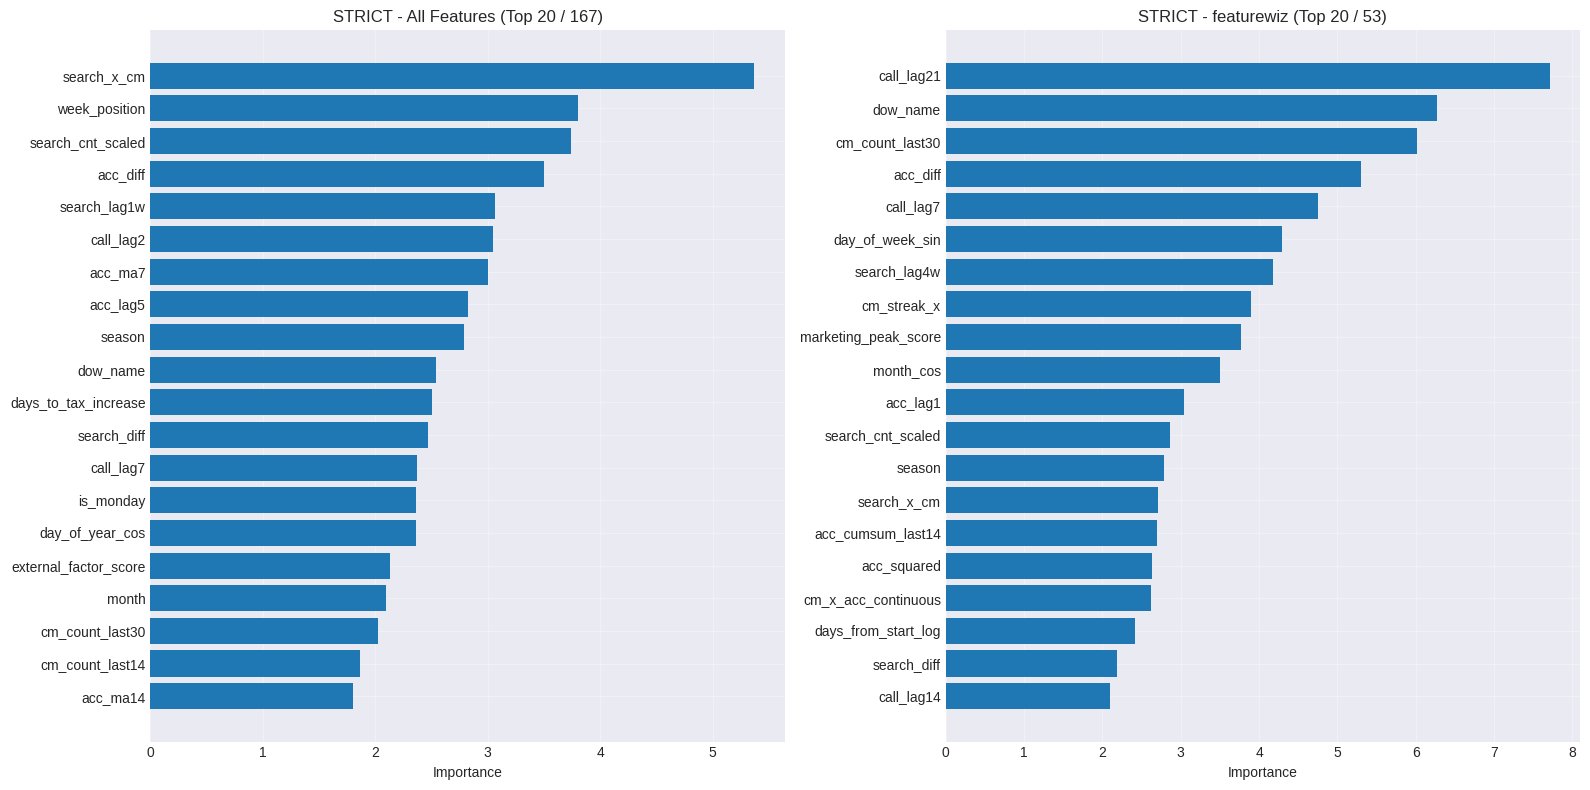


exp02 RELAXED - All Features

Top 20 features (All Features):
                 feature  importance
0               dow_name    6.230411
1               acc_lag1    4.741017
2                    day    3.888665
3              call_lag7    3.582479
4            acc_get_cnt    3.315769
5               acc_ma30    2.897325
6               acc_7dma    2.491349
7          week_position    2.198781
8              call_lag2    2.168152
9                cm_x_q3    1.917650
10           search_diff    1.875363
11  marketing_peak_score    1.855749
12              acc_diff    1.853609
13         is_busy_month    1.826122
14      acc_cumsum_last7    1.784506
15             is_monday    1.677359
16             call_lag3    1.668039
17        cm_count_last7    1.666418
18            call_lag21    1.632673
19         is_early_week    1.627275

Top 20 features (featurewiz):
                    feature  importance
0                  dow_name   12.176673
1               acc_squared    6.318072
2        

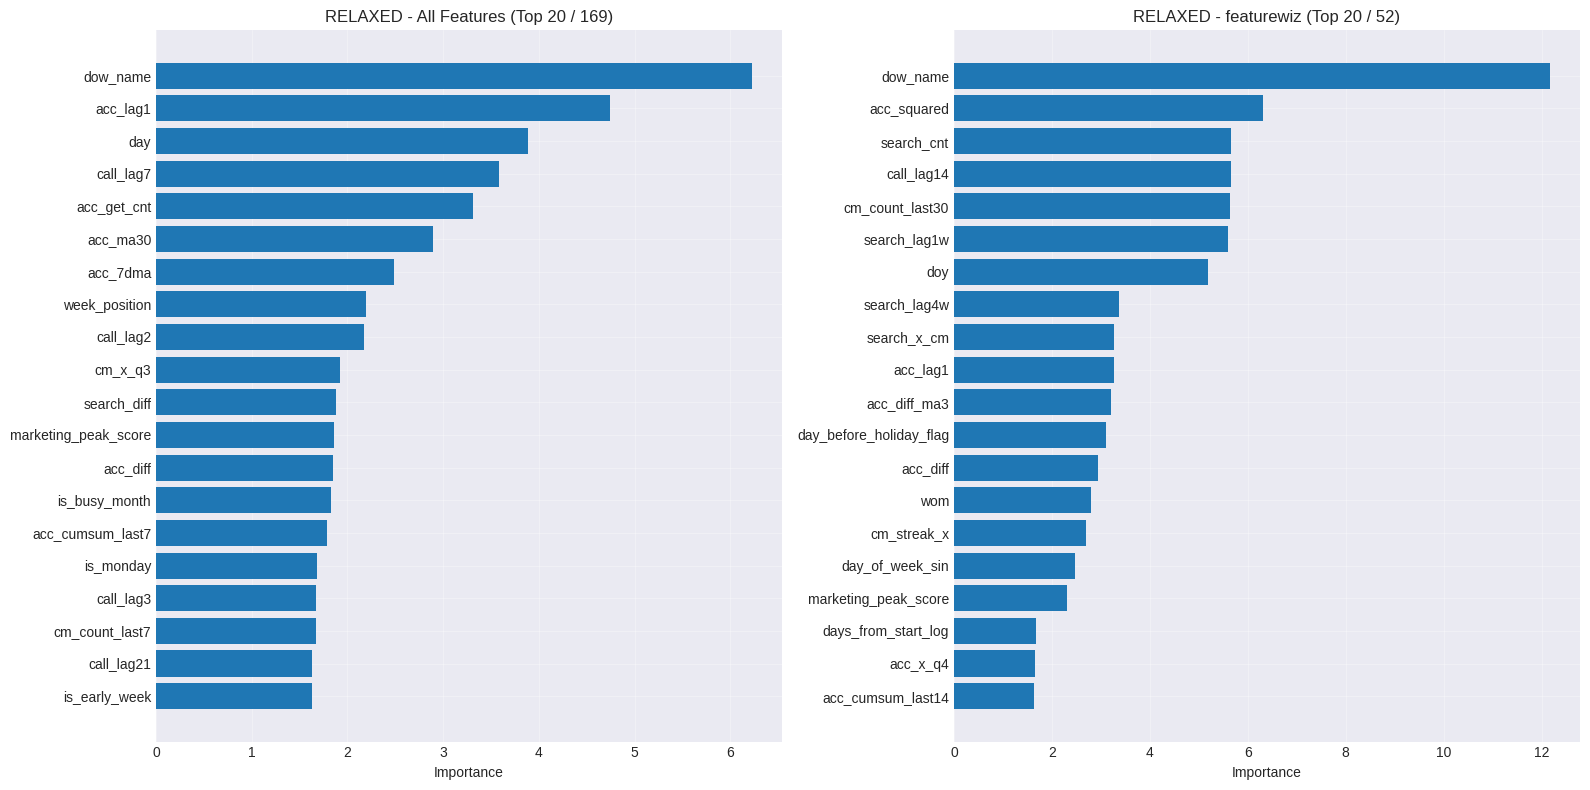


Top 10 Features Comparison (4 models)
       STRICT_all            STRICT_fw   RELAXED_all      RELAXED_fw
      search_x_cm           call_lag21      dow_name        dow_name
    week_position             dow_name      acc_lag1     acc_squared
search_cnt_scaled      cm_count_last30           day      search_cnt
         acc_diff             acc_diff     call_lag7      call_lag14
     search_lag1w            call_lag7   acc_get_cnt cm_count_last30
        call_lag2      day_of_week_sin      acc_ma30    search_lag1w
          acc_ma7         search_lag4w      acc_7dma             doy
         acc_lag5          cm_streak_x week_position    search_lag4w
           season marketing_peak_score     call_lag2     search_x_cm
         dow_name            month_cos       cm_x_q3        acc_lag1


In [93]:
# exp02の特徴量重要度を可視化
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===== STRICT版 =====
print("="*60)
print("exp02 STRICT - All Features")
print("="*60)

# 全特徴量版
strict_all = pd.read_csv("../output/exp02/strict/feature_importance_all.csv")
print(f"\nTop 20 features (All Features):")
print(strict_all.head(20))

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# All features
ax = axes[0]
top20_all = strict_all.head(20).sort_values('importance')
ax.barh(range(len(top20_all)), top20_all['importance'])
ax.set_yticks(range(len(top20_all)))
ax.set_yticklabels(top20_all['feature'])
ax.set_xlabel('Importance')
ax.set_title(f'STRICT - All Features (Top 20 / {len(strict_all)})')
ax.grid(True, alpha=0.3)

# featurewiz版
strict_fw = pd.read_csv("../output/exp02/strict/feature_importance_featurewiz.csv")
print(f"\nTop 20 features (featurewiz):")
print(strict_fw.head(20))

ax = axes[1]
top20_fw = strict_fw.head(20).sort_values('importance')
ax.barh(range(len(top20_fw)), top20_fw['importance'])
ax.set_yticks(range(len(top20_fw)))
ax.set_yticklabels(top20_fw['feature'])
ax.set_xlabel('Importance')
ax.set_title(f'STRICT - featurewiz (Top 20 / {len(strict_fw)})')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/exp02/strict/feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("exp02 RELAXED - All Features")
print("="*60)

# ===== RELAXED版 =====
relaxed_all = pd.read_csv("../output/exp02/relaxed/feature_importance_all.csv")
relaxed_fw = pd.read_csv("../output/exp02/relaxed/feature_importance_featurewiz.csv")

print(f"\nTop 20 features (All Features):")
print(relaxed_all.head(20))

print(f"\nTop 20 features (featurewiz):")
print(relaxed_fw.head(20))

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

ax = axes[0]
top20_all = relaxed_all.head(20).sort_values('importance')
ax.barh(range(len(top20_all)), top20_all['importance'])
ax.set_yticks(range(len(top20_all)))
ax.set_yticklabels(top20_all['feature'])
ax.set_xlabel('Importance')
ax.set_title(f'RELAXED - All Features (Top 20 / {len(relaxed_all)})')
ax.grid(True, alpha=0.3)

ax = axes[1]
top20_fw = relaxed_fw.head(20).sort_values('importance')
ax.barh(range(len(top20_fw)), top20_fw['importance'])
ax.set_yticks(range(len(top20_fw)))
ax.set_yticklabels(top20_fw['feature'])
ax.set_xlabel('Importance')
ax.set_title(f'RELAXED - featurewiz (Top 20 / {len(relaxed_fw)})')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/exp02/relaxed/feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== 4つのモデルを横並び比較 =====
print("\n" + "="*60)
print("Top 10 Features Comparison (4 models)")
print("="*60)

comparison_df = pd.DataFrame({
    'STRICT_all': strict_all.head(10)['feature'].values,
    'STRICT_fw': strict_fw.head(10)['feature'].values,
    'RELAXED_all': relaxed_all.head(10)['feature'].values,
    'RELAXED_fw': relaxed_fw.head(10)['feature'].values
})

print(comparison_df.to_string(index=False))